In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
%matplotlib inline

In [3]:
df = pd.read_csv('dataset.csv')

In [4]:
kategori = ['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Revenue']
numerikal = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',  
             'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues','SpecialDay']
date = ['Month']

## Missing Value

In [5]:
df.isna().sum()

Administrative             111
Administrative_Duration    633
Informational                0
Informational_Duration       0
ProductRelated               0
ProductRelated_Duration    639
BounceRates                 74
ExitRates                    0
PageValues                   0
SpecialDay                   0
Month                        0
OperatingSystems           524
Browser                      0
Region                       0
TrafficType                  0
VisitorType                  0
Weekend                      0
Revenue                      0
dtype: int64

Dikarenakan jumlah data numerik yang null berpotensi cukup banyak, bisa kita fill menggunakan median. Dipilih median karena sebaran data yang skew ke kanan, sehingga nilai mean lebih tinggi dari median.

In [6]:
df['Administrative'] = df['Administrative'].fillna(value=df['Administrative'].median())
df['Administrative_Duration'] = df['Administrative_Duration'].fillna(value=df['Administrative_Duration'].median())
df['ProductRelated_Duration'] = df['ProductRelated_Duration'].fillna(value=df['ProductRelated_Duration'].median())
df['BounceRates'] = df['BounceRates'].fillna(value=df['BounceRates'].median())

Data kategorikal yang null tidak terlalu banyak sehingga bisa kita drop

In [7]:
df = df.dropna(subset=['OperatingSystems'])

In [8]:
df.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

## Duplicated Data

In [9]:
df.duplicated().sum()

694

Hapus duplikat tapi simpan nilai yang pertama muncul.

In [10]:
df = df.drop_duplicates(keep='first')

In [11]:
df.duplicated().sum()

0

## Handle Categorical

### Grouping

Penamaan data kategorikal berdasarkan EDA di stage 1

In [12]:
df.Region = df.Region.astype('string').replace(['1', '2', '3', '4', '5', '6', '7', '8', '9'],
                      ['Jakarta', 'Bandung', 'Surabaya', 'Medan', 'Batam', 'Makassar', 'Tangerang', 'Yogyakarta', 'Semarang'])

df.Browser = df.Browser.astype('string').replace(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'],
                                ['Safari', 'Google Chrome', 'Internet Explorer', 'Mozilla Firefox', 'Microsoft Edge', 'Samsung Internet', 'Maxthon Browser', 'Brave', 'Vivaldi', 'UC Browser', 'DuckDuckGo', 'Opera', 'Netscape Navigator'])

df.OperatingSystems = df.OperatingSystems.astype('string').replace(['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0'],
                                                  ['iOS', 'Windows', 'Android', 'MAC OS', 'Blackberry', 'Chrome Os', 'Unix', 'Linux'])

df.TrafficType = df.TrafficType.astype('string').replace(['1', '2', '3', '4', '5', '6', '8', '10', '13'],
                                        ['Organic Search', 'Paid Search', 'Direct Traffic', 'Social Media', 'Facebook Ads', 'Referral Traffic', 'Email Marketing ', 'Display Advertising', 'Affiliate Marketing'])

beberapa data memiliki count yang sangat kecil seperti :  
  
- VisitorType : Other  
- Operating system : 4 (Mac OS), 5 (Blackberry OS), 6 (Chrome OS), 7 (Unix), 8  
- browser : 7 (Maxthon), 9 (Vivaldi), 11 (DuckDuckGo), 12 (Opera), 13 (Netscape)  
- traffic type : 9,7,12,14,15,16,17,18,19  
data ini memiliki potensi untuk didrop atau digabung menjadi "other"  

In [13]:
df = df.drop(df.loc[df['VisitorType'] =='Other'].index) 

In [14]:
os_replace = ['MAC OS', 'Blackberry', 'Chrome Os', 'Unix', 'Linux']
browser_replace =  ['Maxthon Browser', 'Vivaldi', 'DuckDuckGo', 'Opera', 'Netscape Navigator']
traffic_replace = ['9','7','12','14','15','16','17','18','19']

In [15]:
df['OperatingSystems'] = df['OperatingSystems'].astype('string').replace(to_replace=os_replace,value='other')
df['Browser'] = df['Browser'].astype('string').replace(to_replace=browser_replace,value='other')
df['TrafficType'] = df['TrafficType'].astype('string').replace(to_replace=traffic_replace,value='other')

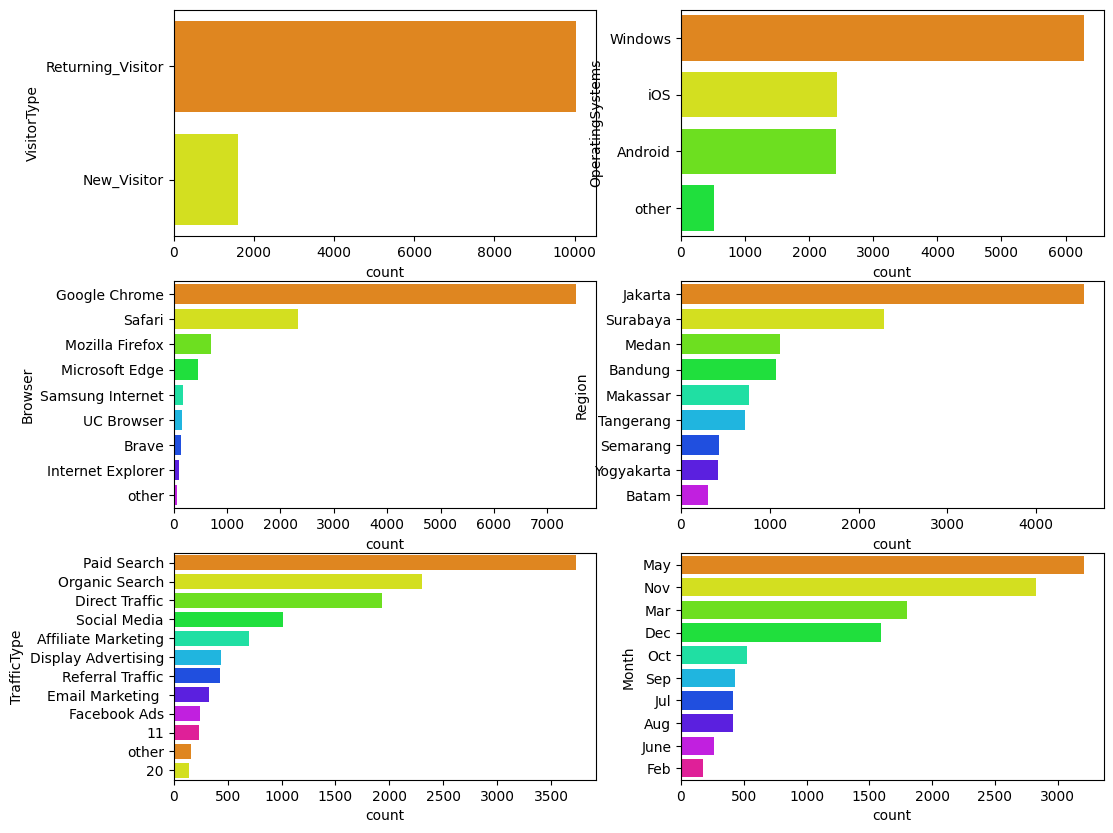

In [16]:
cat2 = ['VisitorType','OperatingSystems', 'Browser', 'Region', 'TrafficType','Month']
palette = sns.color_palette("hsv", 10)
plt.figure(figsize=(12, 10))
for i in range(0,len(cat2)):
    plt.subplot(3,2,i+1)
    sns.countplot(y=df[cat2[i]],order = df[cat2[i]].value_counts().index,palette=palette)

### Feature encoding

Semua fitur kategorikal tidak memiki sifat berurutan atau memiliki derajat, sehingga bisa dilakukan one hot encoding.

In [17]:
from sklearn.preprocessing import OneHotEncoder

columns_to_encode = ['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend','Month']
df = pd.get_dummies(df, columns=columns_to_encode)

## Handling Numerical

### Outlier

In [18]:
outlier = ['Administrative','Administrative_Duration','Informational','Informational_Duration',
           'ProductRelated','ProductRelated_Duration','BounceRates','ExitRates',
           'PageValues']

Dikarenakan sebaran data yang skew ke kanan, diterapkan log transformation untuk menormalkan sebaran data

In [19]:
for num in df[outlier]:
    min_value = df[df[num] > 0][num].min() / 2
    df[num] = np.log(df[num] + min_value)

In [20]:
print(f'Jumlah baris sebelum memfilter outlier: {len(df)}')

filtered_entries = np.array([True] * len(df))

for col in outlier:
    zscore = abs(stats.zscore(df[col])) 
    filtered_entries = (zscore < 3) & filtered_entries
    
df_zscore = df[filtered_entries] 

print(f'Jumlah baris setelah memfilter outlier: {len(df_zscore)}')

Jumlah baris sebelum memfilter outlier: 11649
Jumlah baris setelah memfilter outlier: 10719


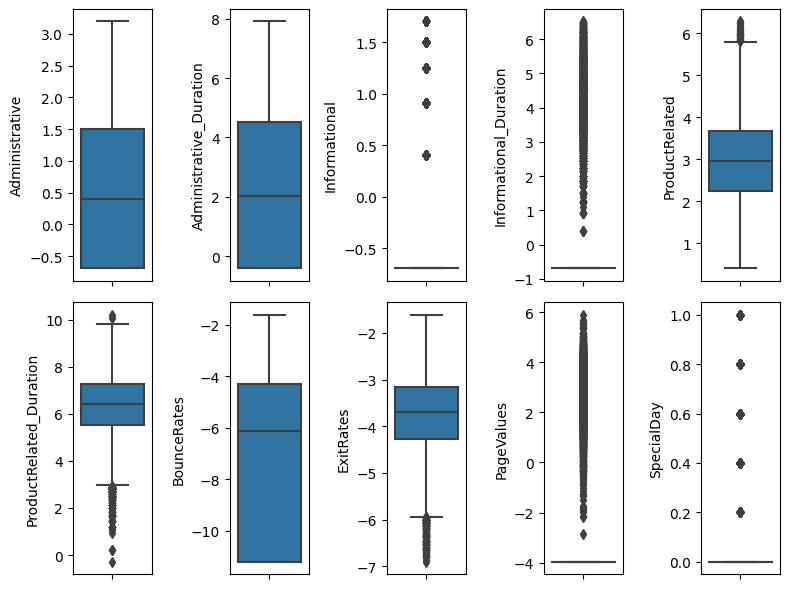

In [21]:
plt.figure(figsize=(8, 6))
for i in range(0,len(numerikal)):
    plt.subplot(2,5,i+1)
    sns.boxplot(y=df_zscore[numerikal[i]],orient='v')
    plt.tight_layout()

### Splitting Data

Sebelum scaling data, dilakukan splitting terlebih dahulu untuk menghindari data leakage

In [22]:
from sklearn.model_selection import train_test_split


X = df.drop(columns=['Revenue'])
y= df['Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (9319, 58)
X_test shape: (2330, 58)
y_train shape: (9319,)
y_test shape: (2330,)


### Scaling Data

Dilakukan scaling data menggunakan standardisasi. Dipilih standardisasi karena tidak terlalu sensitif ke outlier

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train) 
X_train_scaled = scaler.transform(X_train)  
X_test_scaled = scaler.transform(X_test) 

In [24]:
df['Revenue'].value_counts(normalize=True)* 100

Revenue
False    84.376341
True     15.623659
Name: proportion, dtype: float64

<span style="font-size:25px;">**Handling Class Imbalance**

Karena fitur dependant bersifat sangat imbalance, dilakukan handling menggunakan teknik SMOTE

In [38]:
from imblearn.over_sampling import SMOTE
from collections import Counter


smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_scaled, y_train)

print('Original dataset shape:', Counter(y_train))
print('Resampled dataset shape:', Counter(y_res))


Original dataset shape: Counter({False: 7854, True: 1465})
Resampled dataset shape: Counter({False: 7854, True: 7854})


In [43]:
print('Original dataset shape:', X_train_scaled.shape)
print('Resampled dataset shape:', X_res.shape)

Original dataset shape: (9319, 58)
Resampled dataset shape: (15708, 58)


<span style="font-size:25px;">**Feature Engineering**

In [26]:
numerikal2 =  ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',  
             'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues',
               'SpecialDay','Revenue']


<AxesSubplot:>

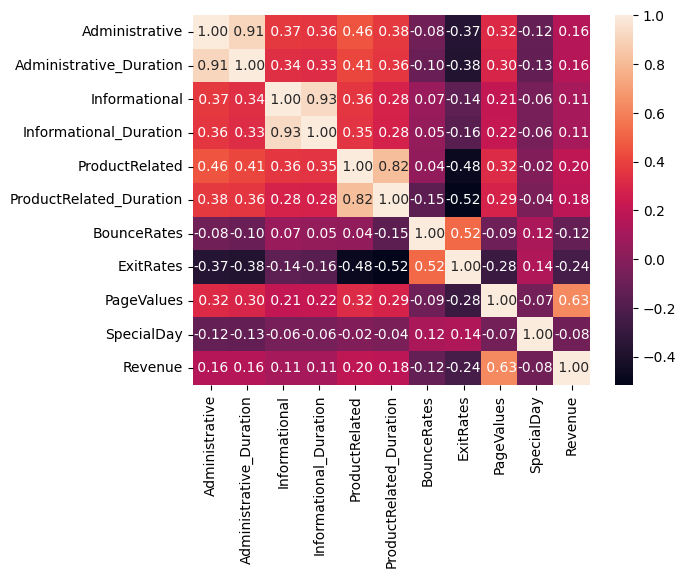

In [27]:
sns.heatmap(df[numerikal2].corr(), annot= True, fmt = ' .2f')

In [28]:
kategori_baru = ['OperatingSystems_Android', 'OperatingSystems_Windows',
       'OperatingSystems_iOS', 'OperatingSystems_other', 'Browser_Brave',
       'Browser_Google Chrome', 'Browser_Internet Explorer',
       'Browser_Microsoft Edge', 'Browser_Mozilla Firefox', 'Browser_Safari',
       'Browser_Samsung Internet', 'Browser_UC Browser', 'Browser_other',
       'Region_Bandung', 'Region_Batam', 'Region_Jakarta', 'Region_Makassar',
       'Region_Medan', 'Region_Semarang', 'Region_Surabaya',
       'Region_Tangerang', 'Region_Yogyakarta', 'TrafficType_11',
       'TrafficType_20', 'TrafficType_Affiliate Marketing',
       'TrafficType_Direct Traffic', 'TrafficType_Display Advertising',
       'TrafficType_Email Marketing ', 'TrafficType_Facebook Ads',
       'TrafficType_Organic Search', 'TrafficType_Paid Search',
       'TrafficType_Referral Traffic', 'TrafficType_Social Media',
       'TrafficType_other', 'VisitorType_New_Visitor',
       'VisitorType_Returning_Visitor', 'Weekend_False', 'Weekend_True',
       'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June',
       'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep']

In [29]:
from scipy.stats import pointbiserialr

correlation_results = {}
for column in df[kategori_baru]:
    if column != 'Revenue':  
        corr, p_value = pointbiserialr(df[column], df['Revenue'])
        correlation_results[column] = corr

for column, correlation in correlation_results.items():
    print(f"Correlation between 'Revenue' and '{column}': {correlation:.2f}")


Correlation between 'Revenue' and 'OperatingSystems_Android': -0.07
Correlation between 'Revenue' and 'OperatingSystems_Windows': 0.07
Correlation between 'Revenue' and 'OperatingSystems_iOS': -0.01
Correlation between 'Revenue' and 'OperatingSystems_other': 0.01
Correlation between 'Revenue' and 'Browser_Brave': 0.00
Correlation between 'Revenue' and 'Browser_Google Chrome': -0.00
Correlation between 'Revenue' and 'Browser_Internet Explorer': -0.03
Correlation between 'Revenue' and 'Browser_Microsoft Edge': 0.02
Correlation between 'Revenue' and 'Browser_Mozilla Firefox': 0.02
Correlation between 'Revenue' and 'Browser_Safari': -0.01
Correlation between 'Revenue' and 'Browser_Samsung Internet': -0.01
Correlation between 'Revenue' and 'Browser_UC Browser': 0.02
Correlation between 'Revenue' and 'Browser_other': 0.00
Correlation between 'Revenue' and 'Region_Bandung': 0.01
Correlation between 'Revenue' and 'Region_Batam': 0.00
Correlation between 'Revenue' and 'Region_Jakarta': 0.02
Cor

**Feature Selection**

Mengdrop feature:  
-Administrative_Duration karena highly correlated dengan Administrative  
-Informational_Duration karena highly correlated dengan Informational  
-ProductRelated_Duration karena highly correlated dengan ProductRelated  
-SpecialDay karena korelasi dengan target sangat rendah  



**Feature Extraction**

Average Session Duration: Menghitung rata-rata waktu yang dihabiskan oleh pelanggan dengan membagi 'ProductRelated_Duration' dan 'ProductRelated'.


**Feature Tambahan**

1. Session hour
2. Has promo
3. Top product related
4. Kategori

**Modelling**

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
def eval_classification(model):
    y_pred = model.predict(X_test_scaled)
    y_pred_train = model.predict(X_res)
    y_pred_proba = model.predict_proba(X_test_scaled)
    y_pred_proba_train = model.predict_proba(X_res)

    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))

    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_res, y_pred_proba_train[:, 1]))
    #
    score = cross_validate(model, X, y, cv=5, scoring='recall', return_train_score=True)
    print('recall (crossval train): '+ str(score['train_score'].mean()))
    print('recall (crossval test): '+ str(score['test_score'].mean()))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')


In [58]:
dt = DecisionTreeClassifier() # inisiasi object dengan nama dt
dt.fit(X_res, y_res) # fit model decision tree dari data train
eval_classification(dt)

Accuracy (Test Set): 0.86
Precision (Test Set): 0.54
Recall (Test Set): 0.63
F1-Score (Test Set): 0.58
roc_auc (test-proba): 0.77
roc_auc (train-proba): 1.00
recall (crossval train): 1.0
recall (crossval test): 0.5412087912087912


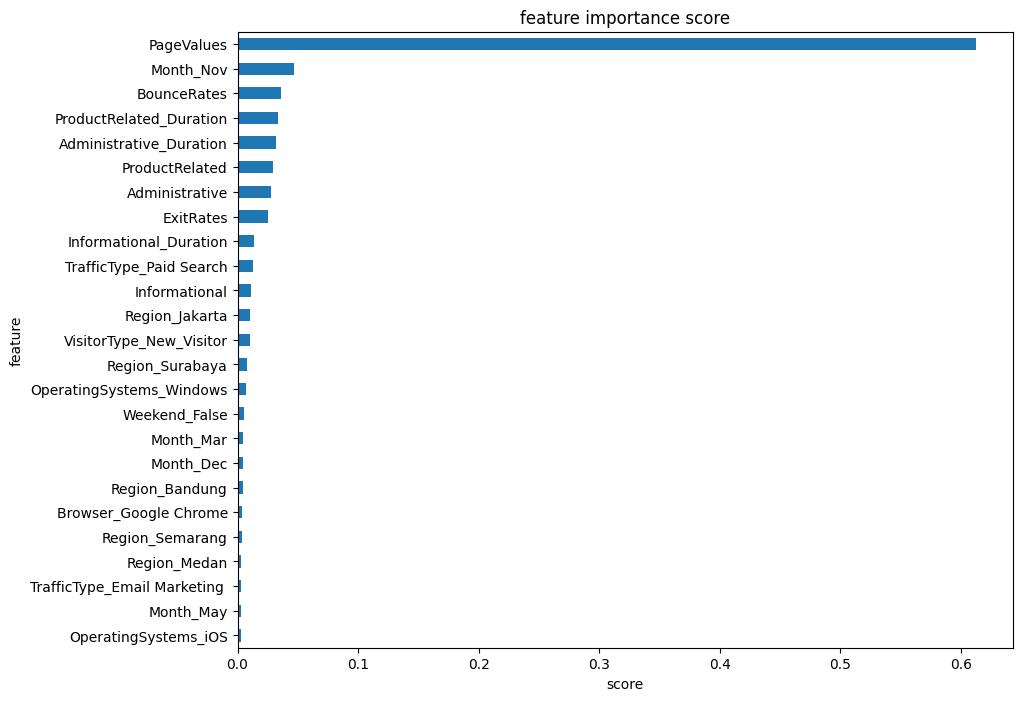

In [61]:
show_feature_importance(dt)

In [54]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform

# List of hyperparameter
max_depth = [int(x) for x in np.linspace(1, 110, num = 30)] # Maximum number of levels in tree
min_samples_split = [2, 5, 10, 100] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4, 10, 20, 50] # Minimum number of samples required at each leaf node
max_features = ['log2', 'sqrt'] # Number of features to consider at every split
criterion = ['gini','entropy']
splitter = ['best','random']

hyperparameters = dict(max_depth=max_depth,
                       min_samples_split=min_samples_split,
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features,
                       criterion=criterion,
                       splitter=splitter
                      )

# Inisialisasi Model
dt = DecisionTreeClassifier(random_state=42)
model = GridSearchCV(dt, hyperparameters, cv=5, scoring='precision')
model.fit(X_res, y_res)

# Predict & Evaluation
y_pred = model.predict(X_test_scaled)#Check performa dari model
eval_classification(model)

Accuracy (Test Set): 0.89
Precision (Test Set): 0.72
Recall (Test Set): 0.42
F1-Score (Test Set): 0.53
roc_auc (test-proba): 0.69
roc_auc (train-proba): 0.69


KeyboardInterrupt: 